# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

##[Feedback]
심화과제라서 데이터셋이 CIFAR10 바뀌지고, 다음번 강의가 CNN을 넘기고
바로 RNN 으로 간다고 들어서,  ANN 대신 CNN 으로 구현을 해보려고 했습니다.  

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import SGD
import numpy as np

#[Feedback]
저의 환경 세팅의 GPU 문제가 있어 해결이 되지 않아 cpu를 쓰게 되였습니다. 환경문제 별도로 문의드리겠습니다.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:08<00:00, 20.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


[Feedback]
어떤 데이터셋인지 이미지를 확인해보았습니다.

50000
torch.Size([3, 32, 32]) 6


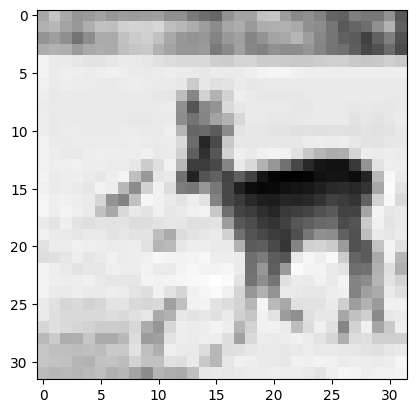

In [4]:
from matplotlib import pyplot as plt
print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[20][0][0], cmap='gray')

In [5]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [20]:
from torch import nn

class SimpleCNN(nn.Module):
     def __init__(self, act_type):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.act_type = act_type

        print("act_type:",act_type)
     def forward(self, x):

        # Layer 1 tensor + activation + pool
        x = self.conv1(x)
        if self.act_type == "Sigmoid":
            x = torch.sigmoid(x)
        elif self.act_type == "Leaky_Relu":
            x = torch.nn.functional.leaky_relu(x, negative_slope=0.01)
            x = self.dropout(x)
        x = self.pool(x)

        # Layer 2 tensor + activation + pool
        x = self.conv2(x)
        if self.act_type == "Sigmoid":
            x = torch.sigmoid(x)
        elif self.act_type == "Leaky_Relu":
            x = torch.nn.functional.leaky_relu(x, negative_slope=0.01)
            x = self.dropout(x)
        x = self.pool(x)

        # Full connection
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        if self.act_type == "Sigmoid":
            x = torch.sigmoid(x)
        elif self.act_type == "Leaky_Relu":
            x = torch.nn.functional.leaky_relu(x, negative_slope=0.01)
            x = self.dropout(x)

        # outlayer
        x = self.fc2(x)
        if self.act_type == "Sigmoid":
            x = torch.sigmoid(x)
        return x

model = SimpleCNN("Leaky_Relu") # 모델 초기화

act_type: Leaky_Relu


##[My Code] Adam 은 momentum 변수가 없다고 하고 SGD는 필요하다고 배웠습니다.

In [8]:
from torch.optim import SGD
from torch.optim import Adam
import torch.nn.functional as F
lr = 0.001

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [9]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [21]:
def training(n_epochs,active_type, optimizer_type):
  model = SimpleCNN(optimizer_type)
  model = model.to(device)
  print(optimizer_type," training:")
  optimizer = None;
  if   optimizer_type == "Adam":
    optimizer = Adam(model.parameters(), lr=lr)
  elif optimizer_type == "SGD":
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)

  train_accs = []
  test_accs  = []

  criterion = None
  for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    for data in trainloader:
      #model.zero_grad()
      optimizer.zero_grad()
      inputs, labels = data

      if active_type == "Sigmoid":
        labels = F.one_hot(labels, num_classes=10).float()  #
        criterion = nn.BCELoss()
      elif active_type == "Leaky_Relu":
        criterion = nn.CrossEntropyLoss()
      inputs, labels = inputs.to(device), labels.to(device)

      preds = model(inputs)
      #loss = (preds[:, 0] - labels).pow(2).mean()
      loss = criterion(preds, labels)

      loss.backward()
      optimizer.step()

      total_loss += loss.item()
    model.eval()
    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch:3d} | Loss: {total_loss} | train_acc: {train_acc} | test_acc: {test_acc}"  )

  return train_accs,test_accs

In [11]:
train_accs_Adam,test_accs_Adam =  training(50,"Leaky_Relu", "Adam")

act_type: Leaky_Relu
Adam  training:
Epoch   0 | Loss: 285.15394401550293 | train_acc: 0.59392 | test_acc: 0.5816
Epoch   1 | Loss: 209.1951104402542 | train_acc: 0.67264 | test_acc: 0.6426
Epoch   2 | Loss: 176.42260098457336 | train_acc: 0.73506 | test_acc: 0.6879
Epoch   3 | Loss: 150.6875188946724 | train_acc: 0.78196 | test_acc: 0.7073
Epoch   4 | Loss: 130.15644413232803 | train_acc: 0.82024 | test_acc: 0.7183
Epoch   5 | Loss: 110.67836943268776 | train_acc: 0.84032 | test_acc: 0.7096
Epoch   6 | Loss: 93.24347242712975 | train_acc: 0.88746 | test_acc: 0.7327
Epoch   7 | Loss: 75.34337252378464 | train_acc: 0.91176 | test_acc: 0.7285
Epoch   8 | Loss: 58.5378131121397 | train_acc: 0.94534 | test_acc: 0.735
Epoch   9 | Loss: 45.34402999281883 | train_acc: 0.96512 | test_acc: 0.7309
Epoch  10 | Loss: 34.58346372842789 | train_acc: 0.98268 | test_acc: 0.744
Epoch  11 | Loss: 26.846074037253857 | train_acc: 0.98494 | test_acc: 0.7342
Epoch  12 | Loss: 20.980075128376484 | train_acc:

In [ ]:
Model_Relu_Adam = model

In [12]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

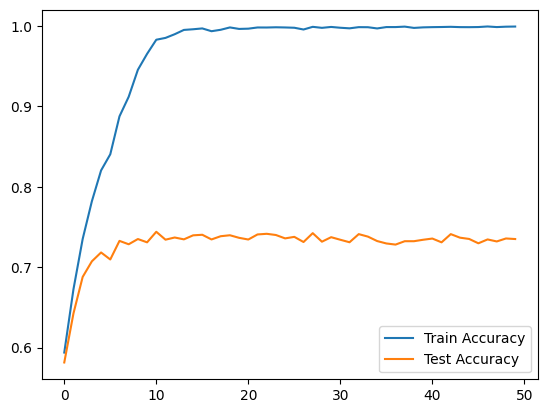

In [13]:
# Epoch에 따른 train과 test data에 대한 model의 정확도를 plot합니다
plot_acc(train_accs_Adam, test_accs_Adam, label1='Train Accuracy', label2='Test Accuracy')

In [22]:
train_accs_SGD,test_accs_SGD =  training(50,"Leaky_Relu", "SGD")

act_type: SGD
SGD  training:
Epoch   0 | Loss: 415.4064246416092 | train_acc: 0.31846 | test_acc: 0.3227
Epoch   1 | Loss: 369.00511717796326 | train_acc: 0.38142 | test_acc: 0.3855
Epoch   2 | Loss: 343.72305560112 | train_acc: 0.41462 | test_acc: 0.4179
Epoch   3 | Loss: 324.18776750564575 | train_acc: 0.4425 | test_acc: 0.443
Epoch   4 | Loss: 310.86367189884186 | train_acc: 0.4596 | test_acc: 0.4575
Epoch   5 | Loss: 300.9603761434555 | train_acc: 0.47674 | test_acc: 0.4718
Epoch   6 | Loss: 292.6099590063095 | train_acc: 0.49116 | test_acc: 0.4906
Epoch   7 | Loss: 285.2901884317398 | train_acc: 0.50192 | test_acc: 0.4988
Epoch   8 | Loss: 278.15688705444336 | train_acc: 0.5095 | test_acc: 0.5064
Epoch   9 | Loss: 271.24184930324554 | train_acc: 0.52454 | test_acc: 0.5174
Epoch  10 | Loss: 265.69651079177856 | train_acc: 0.53856 | test_acc: 0.5317
Epoch  11 | Loss: 260.20627772808075 | train_acc: 0.54224 | test_acc: 0.5377
Epoch  12 | Loss: 255.28944420814514 | train_acc: 0.55524 

In [24]:
Model_Relu_SGD = model

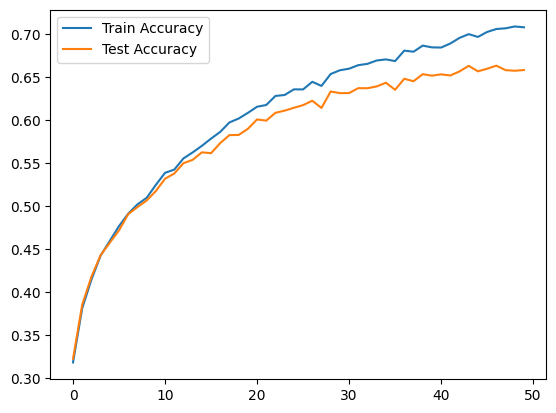

In [23]:
plot_acc(train_accs_SGD, test_accs_SGD, label1='Train Accuracy', label2='Test Accuracy')

In [ ]:
train_accs_SGD_Sigmoid,test_accs_SGD_Sigmoid =  training(50, "Sigmoid", "SGD")

##[FEEDBACK]

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

##[FEEDBACK] 모델 배포한 상태 및 예측값을  볼수가 있습니다.

In [27]:
def lb_check(idx, Model):
  x = trainset[idx][0][None]  # (1, 1, 28, 28)
  x = x.to(device)

  model = Model_Relu_SGD
  logits = model(x)

  print(logits)
  print("오리지널 데이터:",trainset[idx][1])
  predicted_class = torch.argmax(logits, dim=1).item()
  print("모델추출 데이터: ",predicted_class)

  print("--------------------")

  print(len(trainset))
  print(trainset[0][0].shape, trainset[0][1])
  plt.imshow(trainset[idx][0][0], cmap='gray')

  print("--------------------")

  def switch_label(index):
      if index == 0:
          return "airplane"
      elif index == 1:
          return "automobile"
      elif index == 2:
          return "bird"
      elif index == 3:
          return "cat"
      elif index == 4:
          return "deer"
      elif index == 5:
          return "dog"
      elif index == 6:
          return "frog"
      elif index == 7:
          return "horse"
      elif index == 8:
          return "ship"
      elif index == 9:
          return "truck"
      else:
          return "Unknown"

  label_index = trainset[idx][1]
  label_name = switch_label(label_index)

  print(f"index: {label_index}")
  print(f"name: {label_name}")


In [1]:
model = Model_Relu_SGD.to(device)
lb_check(380,model)

NameError: name 'Model_Relu_SGD' is not defined

여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.